#### Deep Learning : AI2100

#### HW3

#### Tanmay Goyal- AI20BTECH11021

In [88]:
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.manifold import TSNE

datasource: https://www.cs.toronto.edu/~kriz/cifar.html.

##### 1. Convolution function

In [153]:
def conv(img ,  kernel , stride = 1 , padding = False, nl_act = 'sigmoid' , relu_parameter = 0.5):
    
    # checking for validity of image and kernel sizes
    (W,H,C) = img.shape
    if C != kernel.shape[2] or kernel.shape[0] != kernel.shape[1]:
        print("Invalid image or kernel size")
        return False
    
    # checking for validity of non linear activation
    if nl_act not in ['sigmoid' , 'relu' , 'tanh' , 'prelu']:
        print("Invalid Non linear activation")
        return False

    k = kernel.shape[0]

    if padding == True:
        pad_size = k-1

        # we have been asked to use reflection padding
        # all the indices have been calculated with care
        padded = np.zeros((W + 2 * pad_size , H + 2 * pad_size , C))

        # copying the image to the center patch
        padded[pad_size : W + pad_size , pad_size : H + pad_size] = img

        # doing reflection padding
        # top and bottom
        padded[:pad_size , :] = np.flip(padded[pad_size + 1 : 2 * pad_size + 1, :] , axis = 0)       # taking reflection
        padded[W + pad_size: , :] = padded[W : W + pad_size, :]
            
        # doing reflection padding
        # sides
        padded[: , :pad_size] = np.flip(padded[: , pad_size + 1 : 2 * pad_size + 1] , axis = 1)     # taking reflection
        padded[: ,H + pad_size:] = padded[: , H : H + pad_size]
        
        
        # flipping kernel
        kernel = kernel[::-1 , ::-1 , :]
    
        # doing the convolution
        output = np.zeros((np.ceil((W + pad_size)/stride).astype(int) ,np.ceil((H + pad_size)/stride).astype(int)))

        for i in range(0,output.shape[0]):
            for j in range(0,output.shape[1]):
                pad_patch = padded[i * stride : i * stride + k , j * stride : j * stride + k , :]
                output[i][j] = np.sum(np.multiply(pad_patch,kernel)) 
    
        # dividing output by sum of kernel
        if(kernel.sum() != 0):
            output = output // kernel.sum()

    
    else:   # padded = False

        # flipping kernel
        kernel = kernel[::-1 , ::-1 , :]
    
        # doing the convolution
        output = np.zeros((np.ceil((W - k + 1)/stride).astype(int) ,np.ceil((H - k + 1)/stride).astype(int)))

        for i in range(0,output.shape[0]):
            for j in range(0,output.shape[1]):
                img_patch = img[i * stride : i * stride + k , j * stride : j * stride + k , :]
                output[i][j] = np.sum(np.multiply(img_patch,kernel)) 
    
        # dividing output by sum of kernel
        if(kernel.sum() != 0):
            output = output // kernel.sum()

    
    # applying non linear activations
    if nl_act == 'sigmoid':
        output_nl = 1 / (1 + np.exp(-output))
    
    elif nl_act == 'relu':
        
        output_nl = np.zeros(output.shape)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i][j] >= 0:
                    output_nl[i][j] = output[i][j]

    elif nl_act == 'tanh':
        output_nl = (np.exp(output) - np.exp(-output))/ (np.exp(output) + np.exp(-output))

    else:           # parametric relu
        output_nl = np.zeros(output.shape)
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i][j] >= 0:
                    output_nl[i][j] = output[i][j]
                else:
                    output_nl[i][j] = output[i][j] * relu_parameter


    return output_nl


##### 2. Pooling function


In [90]:
def pooling(conv_out , size , pool_type = 'max', stride = 1):
    
    # checking validity of type of pooling
    if pool_type not in ['max' , 'avg' , 'norm']:
        print("Invalid Pooling type")
        return False

    (W,H,C) = conv_out.shape

    # assuming size is same across both dimensions
    output = np.zeros((np.ceil((W - size + 1) / stride).astype(int) , np.ceil((H - size + 1) / stride).astype(int) , C))
    # doing the pooling
    
    for c in range(C):
        layer = conv_out[: , : , c]
       
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                patch = layer[i * stride : i * stride + size , j * stride : j * stride + size]
                
                if pool_type == 'max':
                    output[i][j][c] = np.max(patch)
                elif pool_type == 'avg':
                    output[i][j][c] = np.sum(patch) / patch.size
                else:
                    output[i][j][c] = np.sqrt(np.sum(np.power(patch,2)))    # assuming 2-norm

    return output


##### 3. Convolution layer Function

In [91]:
def conv_layer(inp , kernel_shape , n_kernels , stride = 1 , padding = False , nl = 'sigmoid'):

    output = []

    for i in range(n_kernels):
        np.random.seed(i**3)
        kernel = np.random.random(kernel_shape)
        output.append(conv(inp , kernel , stride , padding , nl))

    output_final = np.stack(output , axis = 2)

    print("The shape of the input to the Convolution Layer is : {}".format(inp.shape))
    
    if padding == False:
        print("The shape of the output of the Convolution Layer is (in case of no padding): {} , which matches ((W-k+1)/stride , (H-k+1)/stride)".format(output_final.shape))
    else:
        print("The shape of the output of the Convolution Layer is (in case of padding): {} , which matches ((W+k-1)/stride , (H+k-1)/stride)".format(output_final.shape))
    
        
    return output_final

##### 4. Pooling Layer function

In [154]:
def pooling_layer(inp , size , pool_type , stride):
    
    print("The shape of the input to the Pooling Layer is : {}".format(inp.shape))
    o = pooling(inp , size , pool_type , stride)
    print("The shape of the output of the Pooling Layer is : {}".format(o.shape))
    return o

##### 5. Flattening (unraveling) function

In [155]:
def unravel(inp, output_size):
    np.random.seed(200)
    unraveled = np.ravel(inp)
    flat_matrix = np.random.random((output_size , len(unraveled)))
    output = flat_matrix @ unraveled
    return output

##### 6. MultiLayer Perceptron

In [156]:
def MLP(inp, n_hidden , size_hiddens , nl , output_size):
    np.random.seed(123)

    # INPUT LAYER
    # accounting for bias term
    inp = inp.reshape(inp.shape[0],)
    inp_dash = np.hstack((1 , inp))
    

    # HIDDEN LAYERS
    z_dash = inp_dash
    for i in range(n_hidden):
        weights = np.random.random((size_hiddens[i] , len(z_dash)))
        a = weights @ z_dash
        
        # applying non linearities
        if nl == 'sigmoid':
            z = 1 / (1 + np.exp(-a))

        elif nl == 'relu':
            z = np.zeros(a.shape)
            for i in range(a.shape[0]):
                    if a[i] >= 0:
                        z[i] = a[i]

        elif nl == 'tanh':
            z = (np.exp(a) - np.exp(-a))/ (np.exp(a) + np.exp(-a))

        # appending 1 to z for bias term again
        z_dash = np.hstack((1,z))


    # OUTPUT LAYER
    pre_output_dash = z_dash
    weights = np.random.random((output_size , len(pre_output_dash)))
    output = weights @ pre_output_dash
    softmax_output = np.exp(output) / np.sum(np.exp(output))

    return output , softmax_output

##### 7. Feed Forward path

In [157]:
def feed_forward(inp):
    
    # Convolution layer of 16 kernels of size 3 x 3 x 3 and sigmoid activation
    o1 = conv_layer(inp , (3,3,3) , 16)
    
    # max pooling layer of size 2 x 2 with stride of 2
    o2 = pooling_layer(o1 , 2 , 'max' , 2)
    
    # convolution layer with 8 kernels of size 3 x 3 x C2 and sigmoid Activation. C2 = 16
    o3 = conv_layer(o2 , (3,3,16) , 8)
    
    # Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
    o4 = pooling_layer(o3 , 2 , 'max' , 2)
    
    # Flattening layer
    o5 = unravel(o4 , 1024)
    
    # Perceptron layer
    o_final , o_final_softmax = MLP(o5 , 1 , [256] , 'sigmoid' , 10)

    print("Shape of final output is {}".format(o_final.shape))
    if len(o_final.shape) == 1 or o_final.shape[1] == 1:
        print("The output is indeed a vector!")
    

    print("The final output vector is: {}".format(o_final))
    print("The final output vector of probabilities is: {}".format(o_final_softmax))
    
    return o1 , o2 , o3 , o4 , o5 , o_final , o_final_softmax

In [188]:
# value of C2

print("The value of C2 is 16.")

The value of C2 is 16.


##### 8. Choose one image from each class and output the output vector. Do you see any trend in the output vectors?

In [158]:
# source: https://www.cs.toronto.edu/~kriz/cifar.html

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [159]:
a = unpickle("data_batch_1")
labels = a[b'labels'][:100]
data = a[b'data'][:100 , :]
file_names = a[b'filenames']

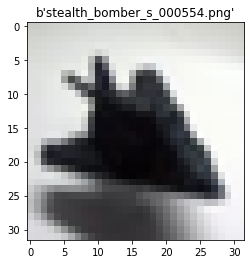

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [160]:
# Class 0: airplane
for i in range(100):
    if labels[i] == 0:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

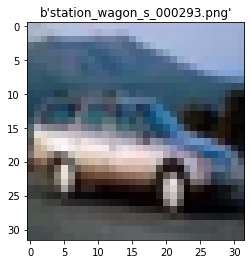

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [161]:
# Class 1: automobile
for i in range(100):
    if labels[i] == 1:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

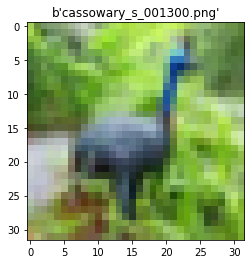

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [162]:
# Class 2: bird
for i in range(100):
    if labels[i] == 2:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

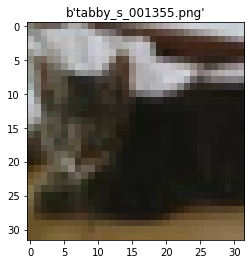

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [163]:
# Class 3: cat
for i in range(100):
    if labels[i] == 3:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

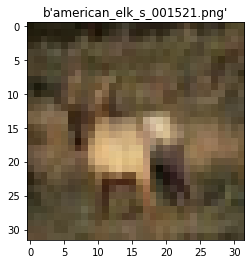

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [164]:
# Class 4: deer
for i in range(100):
    if labels[i] == 4:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

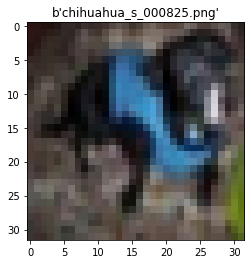

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [165]:
# Class 5: dog
for i in range(100):
    if labels[i] == 5:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

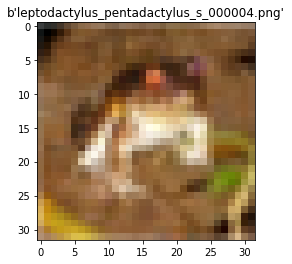

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [166]:
# Class 6: frog
for i in range(100):
    if labels[i] == 6:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

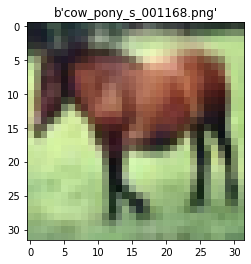

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [167]:
# Class 7: horse
for i in range(100):
    if labels[i] == 7:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

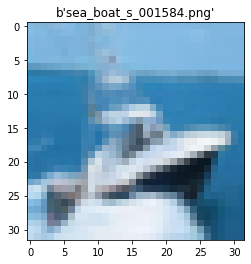

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [168]:
# Class 8: ship
for i in range(100):
    if labels[i] == 8:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

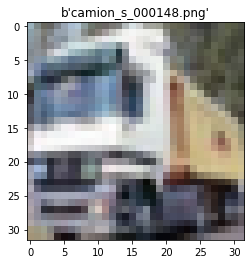

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

In [169]:
# Class 9: truck
for i in range(100):
    if labels[i] == 9:
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        feed_forward(img1)
        break

In [184]:
##### OBSERVATIONS

print("OBSERVATIONS: \n")

print("The trend I see is that all the output vectors across classes is the same irrespective of the input images." 
" This is mainly because I have set a pre-defined random seed for all layers, so that the network begins" 
"with the same set of randomly initialised weights for all classes and inputs. Why we get the same output "
"vector is because the sigmoid activation function acting on the pixels after the convolution results in "
"a complete array of 1s due to the high values of the pixels (approx 200-250). This also shows that the sigmoid is not "
"a preferred activation function. And to continue working with pixel values, ReLu would be a more "
"suitable activation function, since ReLu returns the same value if value > 0.")

OBSERVATIONS: 

The trend I see is that all the output vectors across classes is the same irrespective of the input images. This is mainly because I have set a pre-defined random seed for all layers, so that the network beginswith the same set of randomly initialised weights for all classes and inputs. Why we get the same output vector is because the sigmoid activation function acting on the pixels after the convolution results in a complete array of 1s due to the high values of the pixels (approx 200-250). This also shows that the sigmoid is not a preferred activation function. And to continue working with pixel values, ReLu would be a more suitable activation function, since ReLu returns the same value if value > 0.


##### Visualising the bottleneck layer

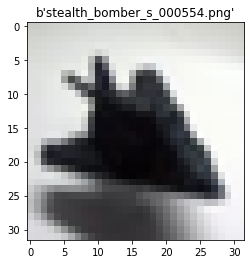

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


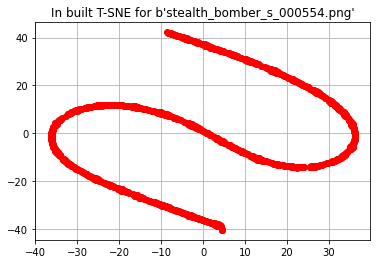

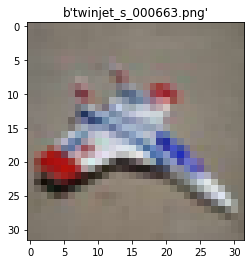

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


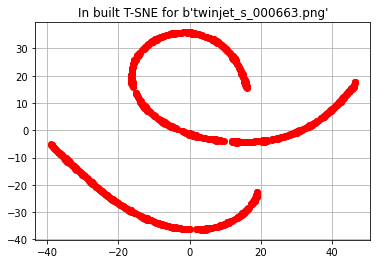

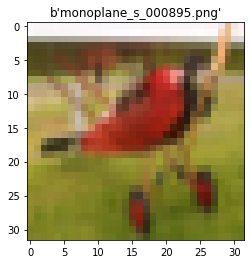

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


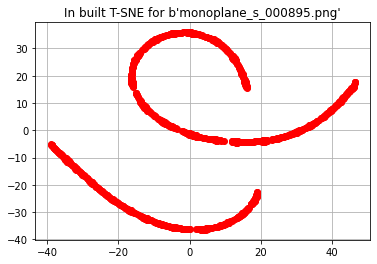

In [170]:
# class 0: airplanes

count = 0
for i in range(100):
    if labels[i] == 0:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

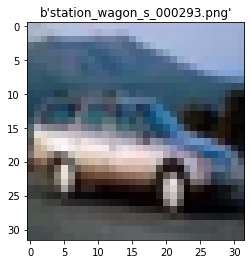

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


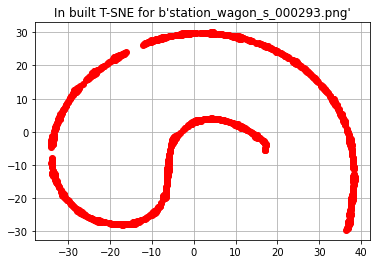

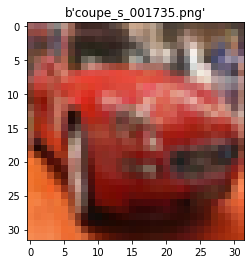

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


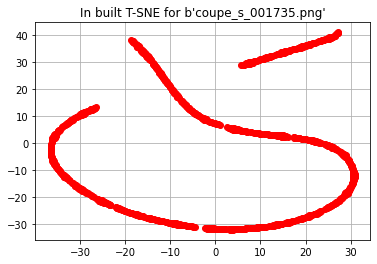

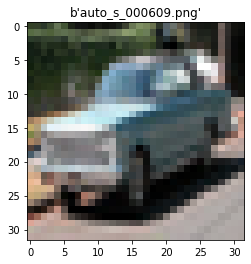

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


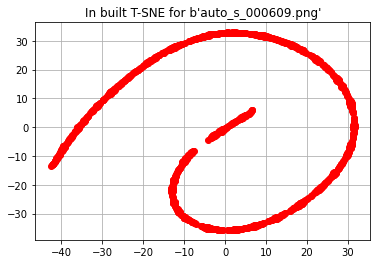

In [171]:
# class 1: automobiles
count = 0
for i in range(100):
    if labels[i] == 1:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

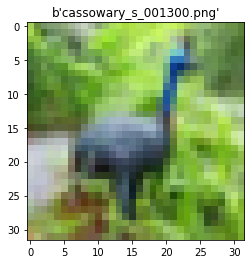

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


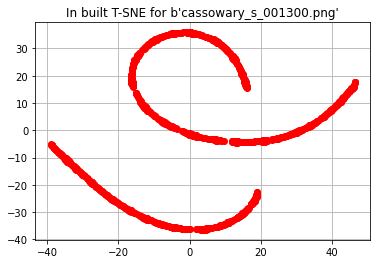

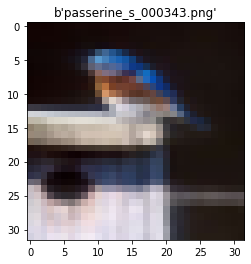

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


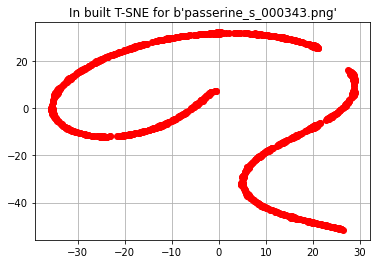

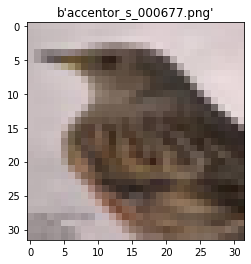

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


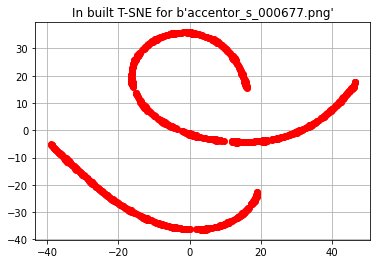

In [172]:
# class 2: birds

count = 0
for i in range(100):
    if labels[i] == 2:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

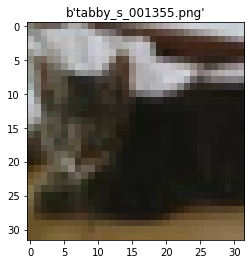

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


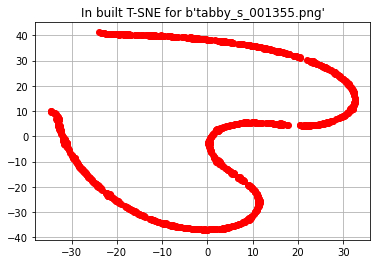

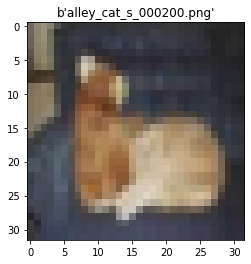

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


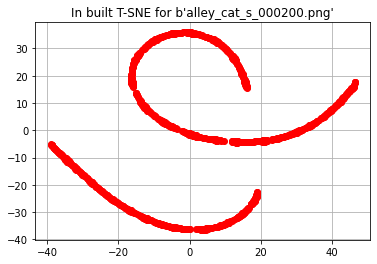

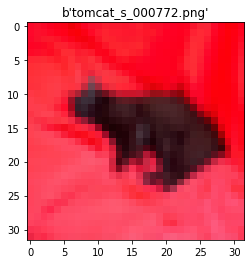

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


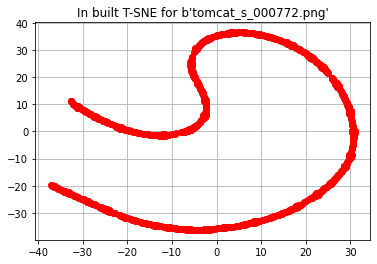

In [173]:
# class 3: cat

count = 0
for i in range(100):
    if labels[i] == 3:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

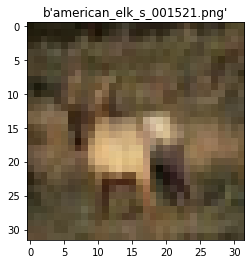

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


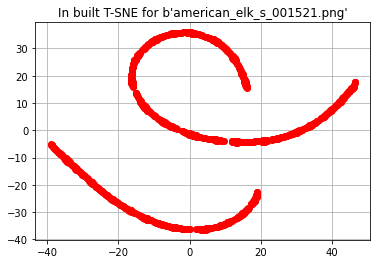

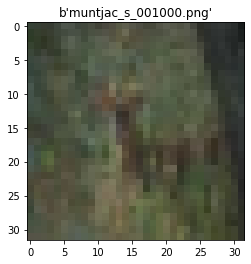

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


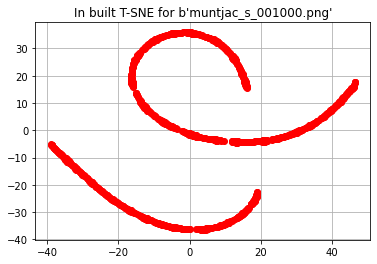

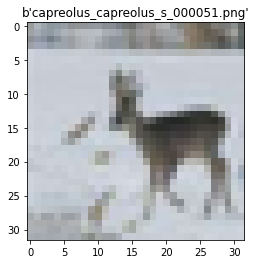

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


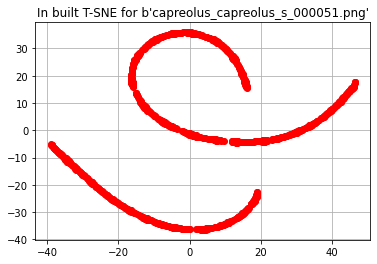

In [174]:
# class 4: deer

count = 0
for i in range(100):
    if labels[i] == 4:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

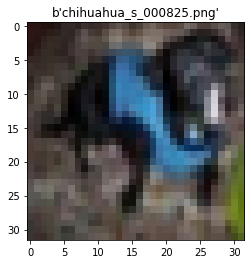

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


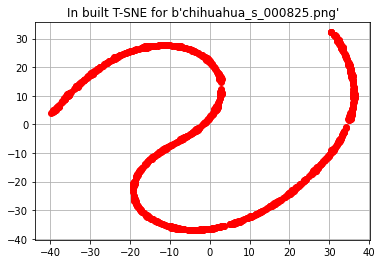

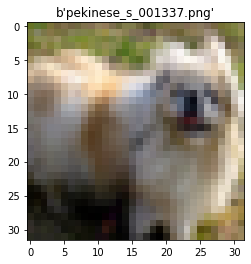

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


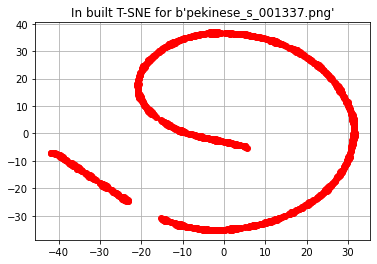

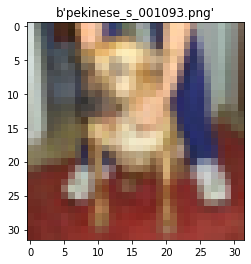

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


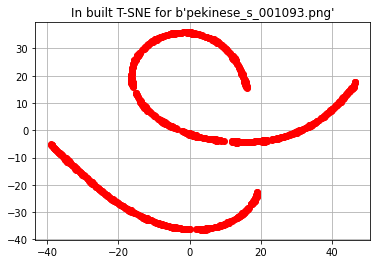

In [175]:
# class 5: dog

count = 0
for i in range(100):
    if labels[i] == 5:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

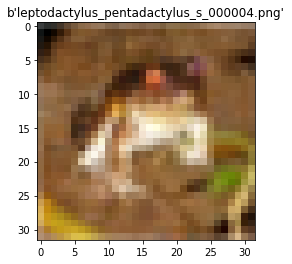

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


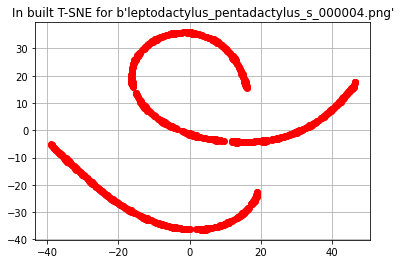

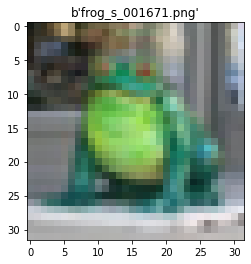

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


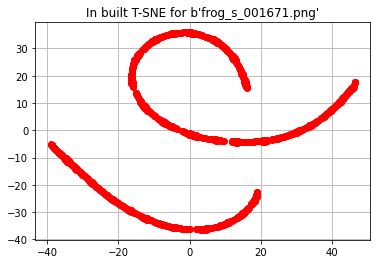

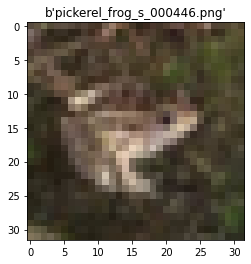

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


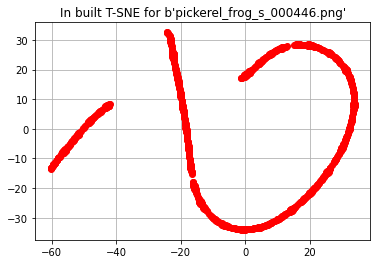

In [176]:
# class 6: frog

count = 0
for i in range(100):
    if labels[i] == 6:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

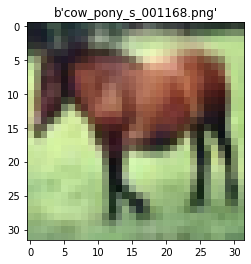

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


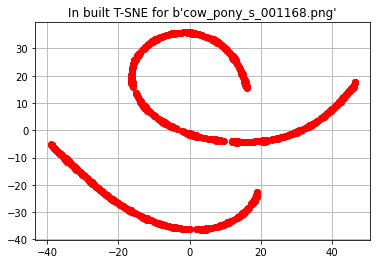

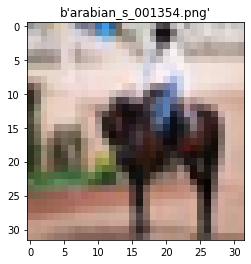

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


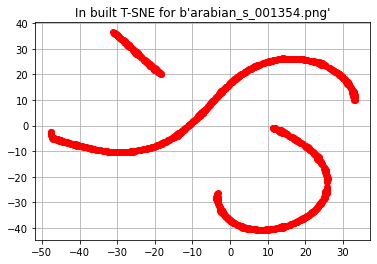

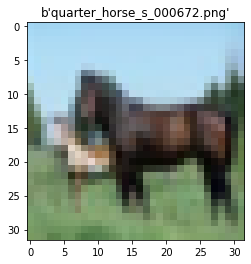

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


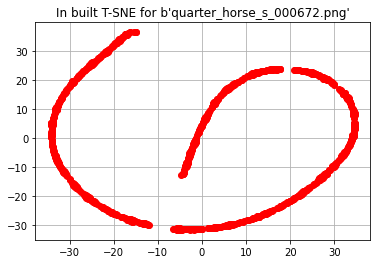

In [177]:
# class 7: horse

count = 0
for i in range(100):
    if labels[i] == 7:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

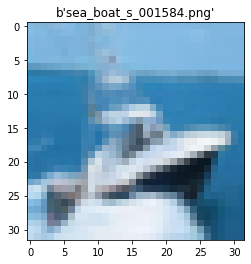

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


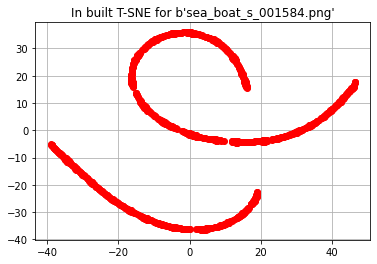

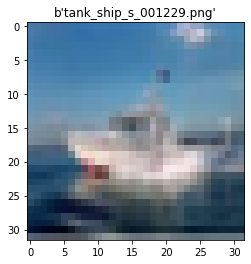

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


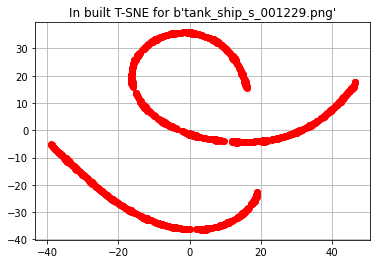

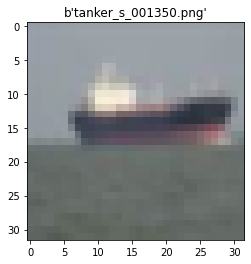

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


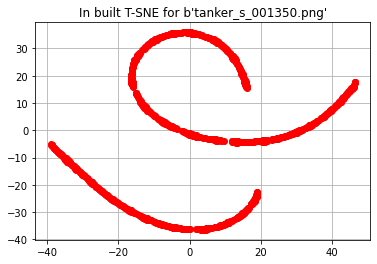

In [178]:
# class 8: ship

count = 0
for i in range(100):
    if labels[i] == 8:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

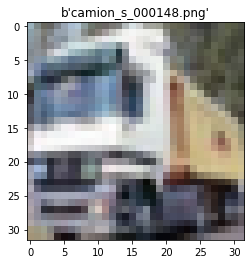

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


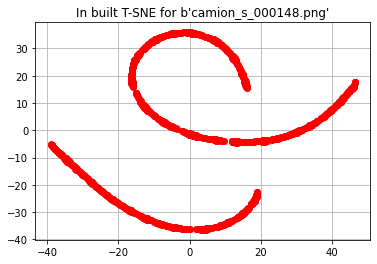

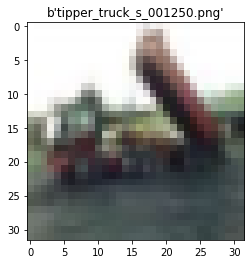

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


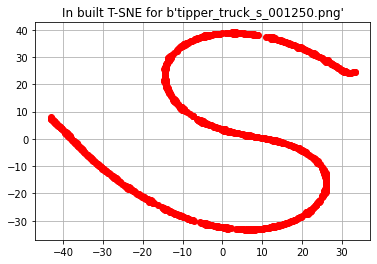

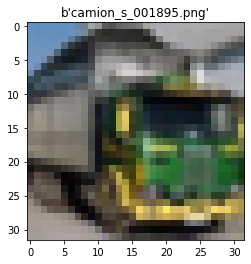

The shape of the input to the Convolution Layer is : (32, 32, 3)
The shape of the output of the Convolution Layer is (in case of no padding): (30, 30, 16) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (30, 30, 16)
The shape of the output of the Pooling Layer is : (15, 15, 16)
The shape of the input to the Convolution Layer is : (15, 15, 16)
The shape of the output of the Convolution Layer is (in case of no padding): (13, 13, 8) , which matches ((W-k+1)/stride , (H-k+1)/stride)
The shape of the input to the Pooling Layer is : (13, 13, 8)
The shape of the output of the Pooling Layer is : (6, 6, 8)
Shape of final output is (10,)
The output is indeed a vector!
The final output vector is: [120.07990048 126.93245104 127.50974596 123.45897239 136.11200056
 123.05969429 133.76501744 127.21044057 130.04777314 130.89792315]
The final output vector of probabilities is: [9.87273395e-08 9.34248324e-05 1.66409581e-04 2.89700814e-06
 9.05920382e-01

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


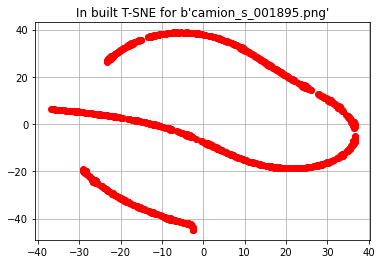

In [179]:
# class 9: truck

count = 0
for i in range(100):
    if labels[i] == 9:
        count += 1
        img1 = data[i]
        name = file_names[i]
        img_r = img1[:1024].reshape((32,32))
        img_g = img1[1024:2048].reshape((32,32))
        img_b = img1[2048:].reshape((32,32))
        img1 = np.stack((img_r , img_g , img_b) , axis = 2) 
        plt.imshow(img1)
        plt.title(name)
        plt.show()
        outputs = feed_forward(img1)
        bn_layer = outputs[4].reshape(-1,1)
        bn_layer_vis = TSNE(n_components = 2).fit_transform(bn_layer)
        plt.plot(bn_layer_vis[:,0] , bn_layer_vis[:,1], 'ro')
        plt.grid(True)
        plt.title("In built T-SNE for {}".format(name))
        plt.show()
        if(count==3):
            break

In [186]:
# OBSERVATIONS

print("OBSERVATIONS: \n")

print("Random Initialisation does lead to some bias. This is because: \n")

print("1) If the weights are very low, we might get very small gradients and values of sigmoids.")

print("2) If the weights are very high, the sigmoids can result in all 1s, which again leads to a different set of problems.")

print("Thus, there is some kind of discriminability we can see.")

OBSERVATIONS: 

Random Initialisation does lead to some bias. This is because: 

1) If the weights are very low, we might get very small gradients and values of sigmoids.
2) If the weights are very high, the sigmoids can result in all 1s, which again leads to a different set of problems.
Thus, there is some kind of discriminability we can see.
